In [120]:
%matplotlib inline

import os
import glob
import json
import time
import copy
import pickle
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from PIL import Image, ImageDraw
import bcolz

import config
import utils

In [121]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [142]:
def csv_predictions_to_array(path):
    frame = pd.read_csv(path)
    d = {}
    for index, row in frame.iterrows():
        d[row['image']] = np.array(row[:-1], dtype=np.float32)
    return np.array([d[k] for k in sorted(d)])


def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2], box[3],
                         color=color, fill=False, linewidth=2)


def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))

In [123]:
info_string = 'fish'
index = 0
prefix = os.path.join('cache', info_string + '_' + str(index))

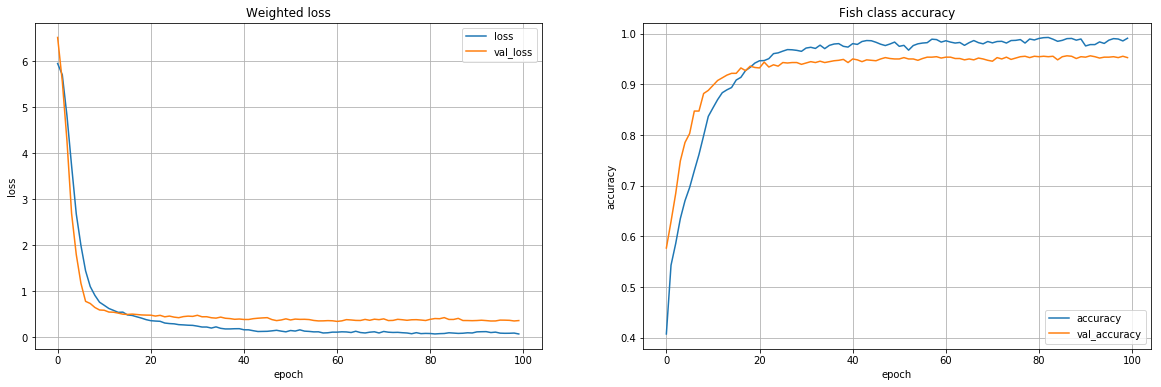

In [124]:
history = pickle.load(open(prefix + '_history.p', 'rb'))

plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history['class_acc'], label='accuracy')
plt.plot(history['val_class_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [125]:
real = csv_predictions_to_array('test_stg1.csv')
pred = csv_predictions_to_array(os.path.join('cache', 'fish_0_2017-02-05-21-05.csv'))

diff = 0
for i in range(len(real)):
    if np.argmax(real[i]) != np.argmax(pred[i]):
        diff += 1

print('Diff:', diff)
print('Log loss:', log_loss(test, pred))

Diff: 342
Log loss: 2.54912626823


In [166]:
X_test = utils.load_array('X_test.bcolz')
Id_test = utils.load_array('Id_test.bcolz')
y_test_bb_tl = utils.load_array('y_test_bb_tl.bcolz')
y_test_bb_wh = utils.load_array('y_test_bb_wh.bcolz')

print('X_test:', np.shape(X_test))
print('Id_test:', np.shape(Id_test))
print('y_test_bb_tl:', np.shape(y_test_bb_tl))
print('y_test_bb_wh:', np.shape(y_test_bb_wh))

Id_test_argsort = np.argsort(Id_test)

def show_pred(i):
    plt.figure(figsize=(9, 12))
    plot(X_test[Id_test_argsort[i]])
    ax = plt.gca()
    print('Id: ', Id_test[Id_test_argsort[i]])
    p = pred[i]
    print('Class: {} ({:.3f})'.format(classes[np.argmax(p)], p[np.argmax(p)]))
    print('Real: ', classes[np.argmax(real[i])])
    box = []
    box.extend(y_test_bb_tl[Id_test_argsort[i]])
    box.extend(y_test_bb_wh[Id_test_argsort[i]])
    print('Box (x,y,w,h): ', box)
    if box[2] > 0 and box[3] > 0:
        ax.add_patch(create_rect_xywh(box, 'yellow'))

X_test: (1000, 448, 448, 3)
Id_test: (1000,)
y_test_bb_tl: (1000, 2)
y_test_bb_wh: (1000, 2)


Id:  img_00730.jpg
Class: BET (0.881)
Real:  YFT
Box (x,y,w,h):  [12.034459, 12.977619, 5.5405626, 6.7539725]


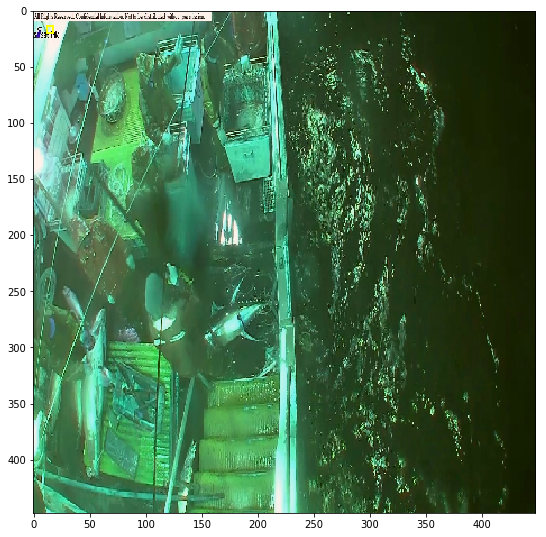

In [168]:
show_pred(100)

In [129]:
pred_p = {}
real_p = {}
for i in range(len(classes)):
    pred_p[classes[i]] = 0
    real_p[classes[i]] = 0

total = 0
for i in range(len(pred)):
    for j in range(len(classes)):
        pred_p[classes[j]] += pred[i][j]
        real_p[classes[j]] += real[i][j]

for i in range(len(classes)):
    pp = pred_p[classes[i]] / len(pred)
    rp = real_p[classes[i]] / len(pred)
    print('{} - pred: {:.4f}, real: {:.4f}'.format(classes[i], pp, rp))

ALB - pred: 0.5919, real: 0.5150
BET - pred: 0.0506, real: 0.0620
DOL - pred: 0.0015, real: 0.0160
LAG - pred: 0.0078, real: 0.0370
NoF - pred: 0.1154, real: 0.1220
OTHER - pred: 0.0286, real: 0.0820
SHARK - pred: 0.0052, real: 0.0300
YFT - pred: 0.1991, real: 0.1360


In [130]:
c_matrix = np.zeros([len(classes), len(classes)])

for i in range(len(pred)):
    predicted = np.argmax(pred[i])
    truelabel = np.argmax(real[i])
    c_matrix[predicted][truelabel] += 1
    
print(c_matrix)

[[ 440.   34.    3.   16.   16.   45.   12.   34.]
 [  17.    7.    1.    5.    1.    2.    7.    7.]
 [   0.    0.    0.    0.    0.    0.    0.    1.]
 [   2.    0.    0.    4.    0.    1.    0.    0.]
 [  11.    1.    0.    0.  101.    2.    0.    0.]
 [  10.    2.    0.    0.    0.   11.    1.    3.]
 [   0.    0.    0.    0.    0.    0.    4.    0.]
 [  35.   18.   12.   12.    4.   21.    6.   91.]]


In [153]:
classes[np.argmax(csv_predictions_to_array('test_stg1.csv')[9])]

'LAG'